<center><img src="https://raw.githubusercontent.com/bazylip/gradient-live-session/main/lab1/img/logo.png" width=100 heigth=100></center>

<center><h1><b>Introduction to Deep Learning</b></h1></center>
<center><h2><b>Gradient PG, 2020</b></h2></center>
<center><h4><b>Bazyli Polednia</b></h4></center>

---
<center><img src="https://raw.githubusercontent.com/bazylip/gradient-live-session/main/lab1/img/colab.png" width=30%></center>

<center><a href="https://colab.research.google.com/github/bazylip/gradient-live-session/blob/main/lab1/introduction_to_deep_learning.ipynb">Run in Google Colab</a></center>

# MNIST Digit Classifier

In this notebook you will get to know the very basics of Tensorflow library and learn how to use it to build a basic network classifying handwritten digits. It is a well-known task, sometimes considered as a "Hello world" problem in AI field. We will mostly use Keras - it is a high-level API coming as submodule of Tensorflow. I highly encourage you to explore more stuff from those libraries - we will deal only with a small part of what they are capable of.

Apart from text sections below, you will also find pre-prepared snippets of code, some of them with \#TODO sections - fill them!

# 1. Prepare the environment

Before you start executing the code, change runtime time of this notebook. Go to "Runtime" → "Change runtime type" and select "TPU". This will enable you to run the notebook faster using the hardware accelerator. If you want to run the whole notebook from the beginning, press Ctrl+F9. If you only want to rerun a certain cell, press Ctrl+Enter while your cursor is in the cell.

Afterwards, let's install necessary libraries which we'll be using.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

#2. Explore the dataset

Our task is to classify handwritten digits from MNIST dataset provided in Keras library. We will import it dividing the images and labels into train set and test set. Train set is the bunch of data we will be using to train the network on, meanwhile test set will be used to evaluate how well our network performs. It's important to remember that **you can't use test set to train the network** - it should only be used to evaluate the permorfance. 

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Remember - the first thing you should always do before jumping straight to designing neural networks is explore the data you are using. Let's start with seeing in what format it is stored and how many images there are.

In [ ]:
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Minimal value: {np.min(train_images)}")
print(f"Maximal value: {np.max(train_images)}")
print("-"*20)
print(f"Train labels: {train_labels}")
print(f"Test labels: {test_labels}")
print(f"Train labels length: {len(train_labels)}")
print(f"Test labels length: {len(test_labels)}")

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Minimal value: 0
Maximal value: 255
--------------------
Train labels: [5 0 4 ... 5 6 8]
Test labels: [7 2 1 ... 4 5 6]
Train labels length: 60000
Test labels length: 10000


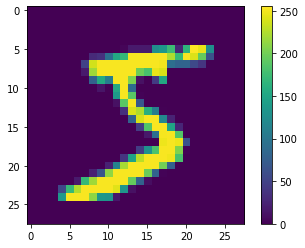

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

As you can see, each image is represented as 28x28 pixel map, where each pixel takes value from 0.0 to 255.0. Label is simply the digit presented on the corresponding image. 

In order to easily pass the image to the network, let's scale the values in each image to range from 0.0 to 1.0 and store them as *float32* type.

In [ ]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

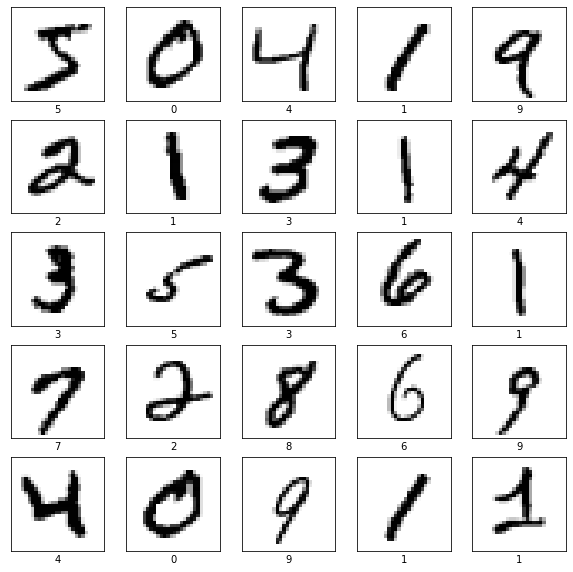

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

#3. Create the network

After we've done some very basic preprocessing and data exploration, let's get to the coolest thing - creating the network! There is no universal rule of thumb when it comes to which network architecture is best for a given problem. Picking the right one is more an art than a science and you can only get needed intuition by solving tens, hundreds and thousands of deep learning problems.

This time we'll go with a very basic network design:

<img src="https://raw.githubusercontent.com/bazylip/gradient-live-session/main/lab1/img/graph.jpg">

Let's take a moment to analyse what we are going to do. First, we create an empty network model. We use "Sequential" type - it means that all layers of the network will be connected one after another. In the next line, we add our first layer of newly created network. It is a dense layer taking a few arguments - number of nodes (512), activation function (ReLU) and shape of the input it receives - here it is a 1D vector of length 784 (28*28), so each input corresponds to a single pixel. Now go ahead and add the second dense layer! It should have 10 nodes and use softmax as activation function - this way n-th node will output the probability of input being "n" e.g. 4th node being equal to 0.4 will mean that there is a 40% that the digit on the image is a "4".



In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(512, 
                                  activation="relu", 
                                  input_shape=(28*28,)))
  #TODO: Add next layer
  
  return model

#4. Train the network

Good job, it looks like we have our network ready! Let's print a summary of it.

In [ ]:
print(create_model().summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_73 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


In this case, "params" mean actual weigth parameters that we will be optimizing during network training. 407,050 parameters for which we have to calculate the gradient - that's quite a lot... Good thing Tensorflow already has it implemented! Let's learn some basics of automatic differentiation before applying it to our network.

##4.1 How to use tf.GradientTape()

GradientTape is one of the core tools in Tensorflow. It allows you to record operations happening during automatic differentiation. Let's compute the gradient for function $y = x^2$ at $x=3$. 

In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
  y = x * x
dy_dx = tape.gradient(y, x)

print(f"dy/dx at x=3.0: {dy_dx}")

dy/dx at x=3.0: 6.0


It's super easy, isn't it? Now try to compute multiple gradient - we have two functions: $y = x^2$ and $z = y^2$, our goal is to compute $\frac{\partial z}{\partial x}$ at $x=3$.

In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
  #TODO: Create y and z functions
dz_dx = #TODO: Calculate the gradient
print(f"dz/dx at x=3.0: {dz_dx}")


dz/dx at x=3.0: 108.0


Let's check: $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} * \frac{\partial y}{\partial x} = 2y(x) \cdot 2x = 4 \cdot x^3 \vert ^{x=3} = 4 \cdot 27 = 108$

Now you see how easy it is to compute the gradients using Tensorflow - you just tell which gradient you want to get and the library does everything for you.

##4.2 Train the network using GradientTape()



Because we engineered our network to take a 1D vector as an input, we have to convert our 28x28 images to match this format. Next, we will create a dataset using `tf.data.Dataset.from_tensor_slices()` - this function divides our images and labels using their first dimension (in our case this dimension is 60000 - dataset size). This way we will have a dataset in which every element will be a 1D vector of size 784 (image) with a label corresponding to it.

 

In [ ]:
original_images = {"train": train_images, "test": test_images}

train_images = train_images.reshape(60000, 28 * 28)
test_images = test_images.reshape(10000, 28 * 28)

train_dataset = tf.data.Dataset.from_tensor_slices(("""TODO: Pass the data"""))

Theoretically, we could say that our dataset is now ready - but there is one thing we could do to improve training performance. Instead of passing the whole dataset to the network at each iteration, we could split it into smaller parts called batches which we will pass to the model one at a time. This approach, called mini-batch gradient descent, will improve efficiency and enable faster convergence. Actually, it's quite a complicated concept - I encourage you to Google it later!

In [ ]:
batch_size = 256
train_dataset = train_dataset.batch(batch_size)

When the network is trained, it needs a reliable metric to know if it's doing better or worse - it's called the loss function. In our example, we'll be using `tf.keras.losses.sparse_categorical_crossentropy` function, which is very commonly used when dealing with classification models with probabilities as outputs. It uses standard cross entropy formula:

$J(W)=\frac{1}{n} \cdot \sum_{i=1}^{n} y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)$

where $y_i$ is the actual label for i-th image and $\hat{y}_i$ is prediction of the model.  

In [ ]:
def compute_loss(true_labels, predictions):
  loss = #TODO: Pass labels and predictions to crossentropy loss function
  return loss

One of the most crucial things during training the network is setting the correct parameters. We've already chosen one - batch size. Now let's add a few more:
* Learning rate - size of steps we take in gradient descent. It can't be too small, because we will find ourselves in local minimum, but it can't be too big either - we will jump all across the loss function and never converge.
* Number of training epochs - how many times we will pass the entire dataset to the model during training.
* Optimizer - determines how the network will be updated after each iteration based on loss value, it basically implements some variant of Stochastic Gradient Descent. For now, we will use Adam optimizer - a relatively new invention which is often used with great results.

I filled the parameters for you, but don't worry - you will experiment with them later! 

In [ ]:
learning_rate = 5e-3
training_epochs = 5
optimizer = tf.optimizers.Adam(learning_rate)

We have defined both our model and loss function, so let's move to backpropagating the gradients. First we will create the model and then define a single train step used during the training. At each step, we want to feed the input batch ($x$) to the model, calculate the loss based on actual labels ($y$) and predictions ($\hat{y}$) and compute the gradients of loss functions with respect to model parameters. The last step will be using our optimizer to adjust weights in the model and return loss value for current step. This task might be the hardest one so far, but when you're done - it will almost be the end!

Hints:
* `tf.keras.models.Sequential()` is callable, so you can pass the data and get predictions simply by calling it and providing input batch as the argument
* You can calculate all gradients at once using a single GradientTape - all model parameters can be found at `model.trainable_variables`
* To backpropagate the gradients, use `apply_gradients` method of our optimizer

If you're not sure what `tf.function` decorator stands for - it takes care of changing our function into Tensorflow graph. You don't have to worry about it for now.

In [ ]:
model = create_model()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = #TODO: Use the model to get predictions

    loss = #TODO: Calculate loss

    gradients = #TODO: Calculate gradients
    
    #TODO: Backpropagate gradients

    return loss

Good job! Now it's finally time to train the network. We will take a batch of images and labels from training dataset and pass it to our train_step function. We will also plot loss value for each step. Before running the cell, try to guess the answer - what will happen with loss value during the training?

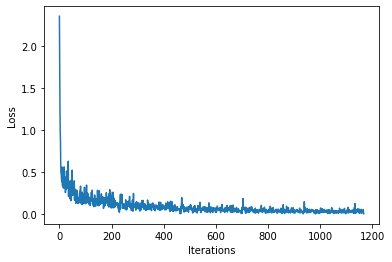

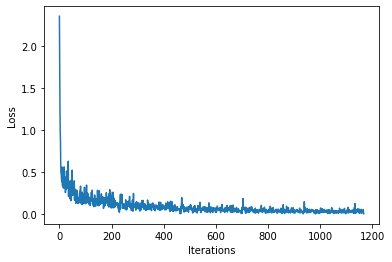

In [ ]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

for epoch in range(training_epochs):
  for step, ("""TODO: Get image and label batch""") in enumerate(train_dataset):
    loss = #TODO: Use our train_step function
    history.append(loss.numpy().mean())
    plotter.plot(history)


As we can see on the plot - loss value decreases over time. It means that our optimizer is correctly using computed gradients to change weights of the network to make it better and better at recognizing handwritten digits. But now we can ask ourselves - how good this model actually is? We can see that the loss decreases, but that doesn't tell us anything about the accuracy of our predictions. 

That's where we will use our test set. Earlier in the notebook we made an assumption - test set can't be used during training. This is really important, because it allows us to check how our model performs on data that it has never seen before.

As our test metric we will use `tf.keras.metrics.SparseCategoricalAccuracy` - it calculates how often actual labels match our predictions. You just need to pass them as arguments - let's try it.

In [ ]:
def evaluate_model(model):
    test_metric = #TODO: Pick test metric
    test_acc = #TODO: Calculate test accuracy
    print(f"Test accuracy: {test_acc*100:.2f}%")

evaluate_model(model)

Test accuracy: 97.11%


If your accuracy is somewhere over 95% - you did it! You've just built your own neural network with the ability to recognize digits. If you are the type of person who doesn't believe something until you see it - let's visualize our predictions. 

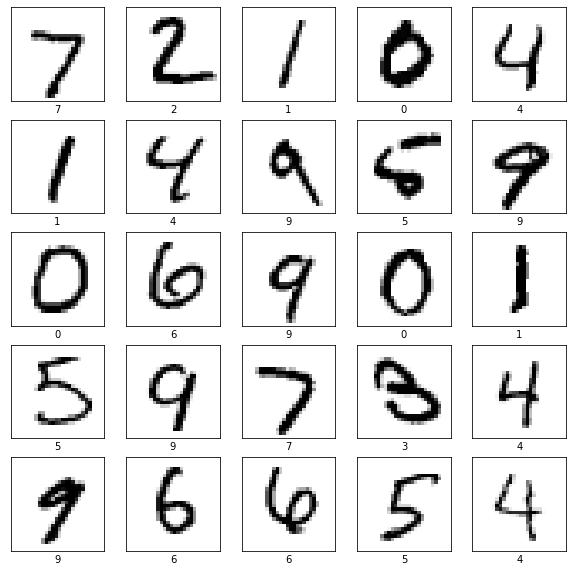

In [ ]:
def plot_predictions(predictions_model):
  predictions = predictions_model.predict(test_images)
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(original_images["test"][i], cmap=plt.cm.binary)
      plt.xlabel(np.argmax(predictions[i]))
  plt.show()

plot_predictions(model)

#4.3 Train the network using model compilation

You successfully created your network but there was quite a lot of coding, wasn't it? We used GradientTape() to see how Tensorflow uses it during the training, but there is a quicker way to implement simple models like this - using model compilation. Instead of creating our own loss function, train step etc., we simply provide the most important parameters to `model.compile()`. In our case it will be the name of the optimizer, loss function and metrics (what metrics we want to evaluate during training). 

In [ ]:
model = create_model()

model.compile(optimizer="""TODO: Pick optimizer""",
              loss="""TODO: Pick loss function""",
              metrics=["accuracy"])

Before we feed the data to the model, we have to change our labels a bit - instead of a single label, we need to convert it to a 1D vector, where all values will be 0 except the value at index equal to the label - it will be 1. Such representation of data is also called one-hot encoding.   

In [ ]:
print(f"Label before encoding: {train_labels[0]}")
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
print(f"Label after encoding: {train_labels[0]}")

Label before encoding: 5
Label after encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


After compilation of the model, we can train the network using `model.fit()`, once again providing necessary arguments. Try to find yourself what you need to pass to it!

In [ ]:
model.fit("""TODO: Pass arguments""")

Epoch 1/5
235/235 [==============================] - 3s 12ms/step - loss: 0.3282 - accuracy: 0.9091
Epoch 2/5
235/235 [==============================] - 3s 12ms/step - loss: 0.1326 - accuracy: 0.9629
Epoch 3/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0893 - accuracy: 0.9744
Epoch 4/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0658 - accuracy: 0.9812
Epoch 5/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0506 - accuracy: 0.9855


And finally, to evaluate how our model performs on new data, we will use `model.evaluate()`.

In [ ]:
test_loss, test_acc = model.evaluate("""TODO: Pass arguments""")
print(f"Test accuracy: {test_acc*100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0730 - accuracy: 0.9774
Test accuracy: 97.74%


As you could see, using model compilation was much faster than writing the whole training implementation yourself. However, bear in mind that sometimes, especially when dealing with more complex network architectures and algorithms, you might find this approach a bit too simplified and that's when writing your own train_step or loss function might come in handy. 

#5. Experiment!

As I said earlier, there are no strict rules in creating neural networks. Nothing limits you, the model will always give you some answers - in the worst case they will just be less accurate than picking them at random. The task for you is to tweak the parameters and see how they affect performance of the model, maybe you will get better accuracy than now? This is also a great moment to explore things that were omitted in this notebook and during the lecture. I would suggest starting with those things:
* Change the number of units in the dense layer
* Add more layers
* Change activation functions
* Change optimizers
* ... and much more!